In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
import torch
import os
import pandas as pd
import numpy as np
import torch.nn as nn
from torch_geometric.data import Data
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.loader import DataLoader
from torch.utils.data import random_split, Dataset

from tqdm import tqdm
from london.utils.process_data import build_train_test_loaders, build_train_test_loaders_2
from london.utils.training import CustomMAELoss, CustomMAPELoss, test_model, get_flow_forecasting_metrics
from london.utils.link_loads import get_graph_attributes, df_to_graph, build_quarter_hour_data, add_missing_nodes, add_missing_nodes_2
from london.utils.models import STGCN
# import networkx as nx

In [3]:
folder_path = "data/london/"
# Get graph attributes, create dfs from csv, process Link column and ordered dfs by time
num_nodes, edge_index, node_mapping, dfs = get_graph_attributes(folder_path)

In [4]:
# Functions
def get_day_time(i):
    if i < 8: # 0500-0700
        return 'Early'
    elif i < 20: # 0700-1000
        return 'AM Peak'
    elif i < 36: # 1000-1600
        return 'Midday'
    elif i < 48: # 1600-1900
        return 'PM Peak'
    elif i < 60: # 1900-2200
        return 'Evening'
    else: # 2200-0500
        return 'Late'

class GraphForVizDataset(Dataset):
    def __init__(self, graphs, edge_index, window_size=4):
        self.graphs = graphs
        self.edge_index = edge_index
        self.window_size = window_size
        self.accesible_data_per_day = len(graphs[0]) - self.window_size
        if self.accesible_data_per_day < 0:
            print(len(graphs[0]))
            raise ValueError("Error : window_size should be lower than the number of graphs per day")
        
    def __len__(self):
        return len(self.graphs) * self.accesible_data_per_day

    def __getitem__(self, idx):
        day = idx//self.accesible_data_per_day
        qh = idx%self.accesible_data_per_day
        day_graphs = self.graphs[day]
        # print(day_graphs)

        # get current and last flows
        last_graphs = day_graphs[qh : qh + self.window_size]
        last_flows = [graph['flows'].values for graph in last_graphs]
        last_flows = torch.tensor(np.array(last_flows), dtype=torch.float32)
        last_flows = last_flows.transpose(0, 1)

        # get data to return
        idx_graph = day_graphs[qh + self.window_size]['flows']
        current_flows = torch.tensor(idx_graph.values, dtype=torch.float32)
        idx_graph = Data(x=last_flows, edge_index=self.edge_index, y=current_flows)
        year = day_graphs[qh + self.window_size]['year']
        day = day_graphs[qh + self.window_size]['day']
        qhr = day_graphs[qh + self.window_size]['qhr']

        # Temporal features: one hot encode day and day_time
        if day not in ['FRI','SAT','SUN']:
            day = 'MTWT'
        df_one_hot_encoding_day = pd.DataFrame(np.zeros((num_nodes, 4)), columns=['MTWT', 'FRI', 'SAT','SUN'])
        df_one_hot_encoding_day[day] = 1.0
        day_time = get_day_time(qh)
        df_one_hot_encoding_day_time = pd.DataFrame(np.zeros((num_nodes, 6)), columns=['Early', 'AM Peak', 'Midday','PM Peak', 'Evening', 'Late'])
        df_one_hot_encoding_day_time[day_time] = 1.0
        temporal_features = pd.concat([df_one_hot_encoding_day, df_one_hot_encoding_day_time], axis=1)
        temporal_features = temporal_features.to_numpy()
        temporal_features = torch.tensor(temporal_features, dtype=torch.float32)

        return idx_graph, year, day, qhr, temporal_features
    

def build_loader(graphs, window_size, batch_size=1, shuffle=True):
    dataset = GraphForVizDataset(graphs, edge_index, window_size)  
    return DataLoader(dataset, batch_size, shuffle)

In [5]:
# Build the Data loader
test_graphs = []
train_graphs = []
window_size = 2
# each df should have the same dimension and same nodes at the same columns
for filename, df in dfs.items():
    day = filename.split('.')[0][-3:]
    year = filename.split('.')[0][-5:-3] 
    df = add_missing_nodes_2(df, node_mapping, num_nodes) # add zeros row for missing nodes
    df_qhrs = [{"flows": df.loc[:,qhr], "year": year, "day": day, "qhr": qhr} for qhr in df.columns]

    if year == '23':
        test_graphs.append(df_qhrs)
    else:
        train_graphs.append(df_qhrs)

train_loader = build_loader(train_graphs, window_size, batch_size=1, shuffle=False)
test_loader = build_loader(test_graphs, window_size, batch_size=1, shuffle=False)

# train_loader, test_loader = build_train_test_loaders_2(graphs, window_size=8, train_split=0.8)

In [6]:
day_order = ['MTWT', 'FRI', 'SAT', 'SUN']
week_passenger = {day: [] for day in day_order}
week_passenger_prediction = {day: [] for day in day_order}
for graph, year, day, qhr, temporal_features in test_loader:
    week_passenger[day[0]].append(graph.y.sum().item())
    temporal_features = temporal_features.squeeze()
week_passenger['MON'] = week_passenger['MTWT'][68:]
week_passenger['TWT'] = week_passenger['MTWT'][:68]

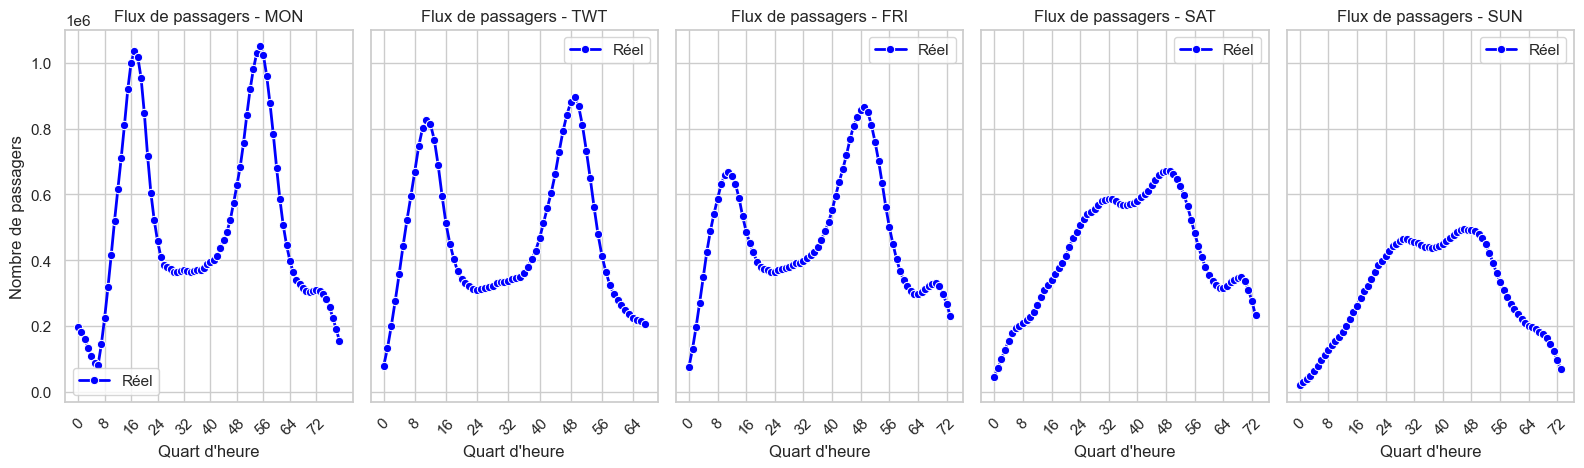

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Appliquer un thème Seaborn
sns.set_theme(style="whitegrid")

# Création des sous-graphiques (1 par jour)
fig, axes = plt.subplots(1, 5, figsize=(16, 5), sharey=True)

for i, day in enumerate(['MON', 'TWT', 'FRI', 'SAT', 'SUN']):
    
    qhr = range(len(week_passenger[day]))  # Index des quarts d'heures
    flux = week_passenger[day]  # Liste des flux pour le jour donné

    # Tracé de la courbe réelle
    sns.lineplot(x=qhr, y=flux, ax=axes[i], color="blue", marker="o", linewidth=2, label="Réel")
    
    # Tracé de la courbe prédite

    axes[i].set_title(f"Flux de passagers - {day}")
    axes[i].set_xlabel("Quart d'heure")
    axes[i].set_ylabel("Nombre de passagers")
    
    # Ajout d'une légende pour distinguer les courbes
    axes[i].legend()

    # Sélectionner les indices pour afficher un tick X tous les 8 quarts d’heure
    ticks = range(0, len(qhr), 8)
    axes[i].set_xticks(ticks)
    axes[i].set_xticklabels(ticks, rotation=45)

# Ajustement de la mise en page
plt.tight_layout()
plt.show()


In [10]:
path = "data/london/Link_Loads_NBT23MON.csv"

In [14]:
df = pd.read_csv(path)
df.columns

Index(['Link', 'Line', 'Dir', 'Order', 'From NLC', 'From ASC', 'From Station',
       'To NLC', 'To ASC', 'To Station',
       ...
       '0230-0245', '0245-0300', '0300-0315', '0315-0330', '0330-0345',
       '0345-0400', '0400-0415', '0415-0430', '0430-0445', '0445-0500'],
      dtype='object', length=113)

In [12]:
df = pd.read_csv(path)
df = df.iloc[:,17:].sum()
qhr = list(df.index)
flux = list(df.values)
print(qhr, flux)

['0500-0515', '0515-0530', '0530-0545', '0545-0600', '0600-0615', '0615-0630', '0630-0645', '0645-0700', '0700-0715', '0715-0730', '0730-0745', '0745-0800', '0800-0815', '0815-0830', '0830-0845', '0845-0900', '0900-0915', '0915-0930', '0930-0945', '0945-1000', '1000-1015', '1015-1030', '1030-1045', '1045-1100', '1100-1115', '1115-1130', '1130-1145', '1145-1200', '1200-1215', '1215-1230', '1230-1245', '1245-1300', '1300-1315', '1315-1330', '1330-1345', '1345-1400', '1400-1415', '1415-1430', '1430-1445', '1445-1500', '1500-1515', '1515-1530', '1530-1545', '1545-1600', '1600-1615', '1615-1630', '1630-1645', '1645-1700', '1700-1715', '1715-1730', '1730-1745', '1745-1800', '1800-1815', '1815-1830', '1830-1845', '1845-1900', '1900-1915', '1915-1930', '1930-1945', '1945-2000', '2000-2015', '2015-2030', '2030-2045', '2045-2100', '2100-2115', '2115-2130', '2130-2145', '2145-2200', '2200-2215', '2215-2230', '2230-2245', '2245-2300', '2300-2315', '2315-2330', '2330-2345', '2345-0000', '0000-0015'

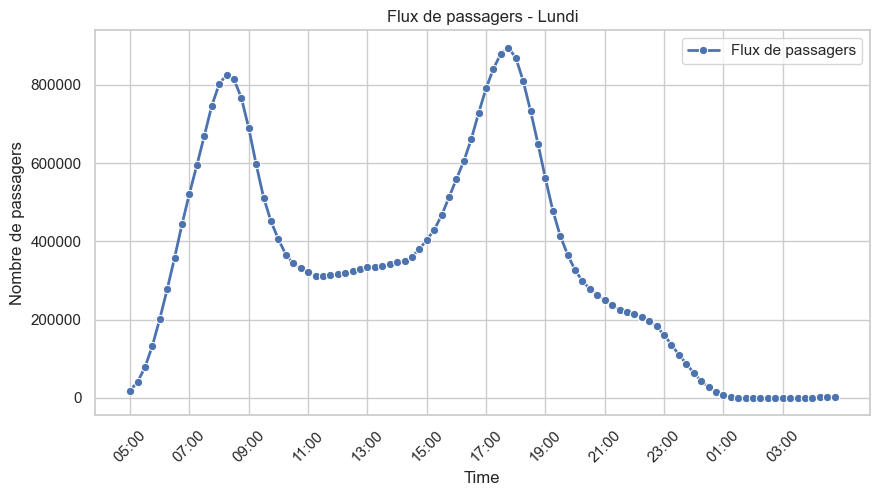

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Appliquer un thème Seaborn
sns.set_theme(style="whitegrid")

# Création du graphique
fig, ax = plt.subplots(figsize=(10, 5))

# Tracé de la courbe réelle
sns.lineplot(x=qhr, y=flux, ax=ax, marker="o", linewidth=2, label="Flux de passagers")

# Configuration des axes
ax.set_title("Flux de passagers - Lundi")
ax.set_xlabel("Time")
ax.set_ylabel("Nombre de passagers")

# Sélection des ticks toutes les 2 heures
hours = [col.split('-')[0] for col in qhr]  # Extraction de l'heure de début
hours = [ h[0:2] + ":" + h[2:4] for h in hours]
ticks = list(range(0, len(qhr), 8))  # 8 quarts d’heure = 2 heures
# ticks = [ str(q)[0:2] +":" + (q)[2:4] for q in ticks]  # Suppression du dernier tick s'il dépasse la longueur
ax.set_xticks(ticks)
ax.set_xticklabels([hours[i] for i in ticks], rotation=45)

# Ajout de la légende et affichage
ax.legend()
plt.show()


In [12]:
n_stations = df.groupby("To NLC").count().shape[0]
(f"There is {n_stations} stations in the metro network")

'There is 471 stations in the metro network'

In [26]:
print(type(df_total.columns[0]))  # Doit afficher <class 'str'>


<class 'str'>


C:\Users\Adrian Serrano\AppData\Local\Temp\ipykernel_138456\1584486932.py:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_total = df_total.applymap(lambda x: int(str(x).replace("\u202f", "").replace(" ", "")))
C:\Users\Adrian Serrano\AppData\Local\Temp\ipykernel_138456\1584486932.py:23: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


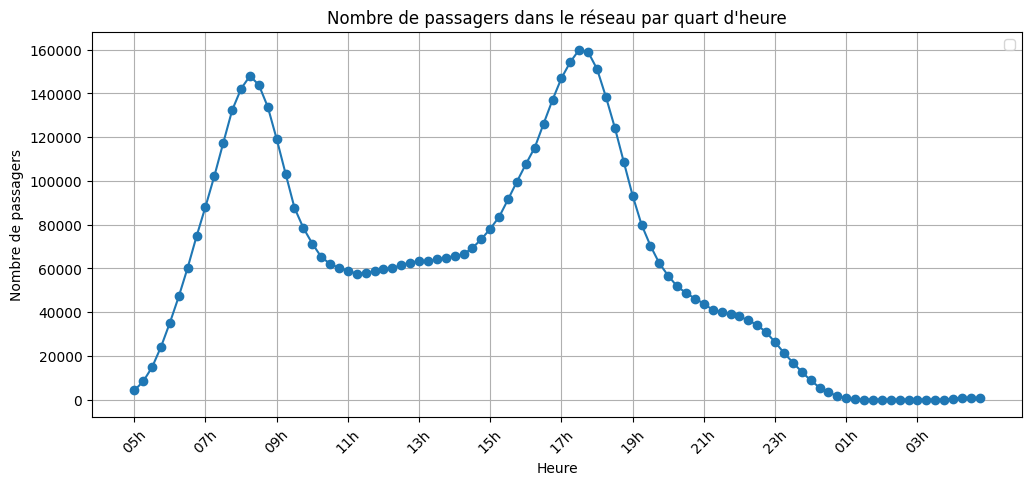

In [31]:
import matplotlib.pyplot as plt

# Convertir les noms des colonnes en str si nécessaire
df_total = df_total.applymap(lambda x: int(str(x).replace("\u202f", "").replace(" ", "")))
df_total.columns = df_total.columns.astype(str)

# Sélection de la première ligne
y_values = df_total.iloc[0].astype(int)  

# Création du graphique
plt.figure(figsize=(12, 5))
plt.plot(df_total.columns, y_values, marker='o', linestyle='-')

# Configuration des ticks (une heure toutes les 2 heures)
time_labels = [col.split('-')[0][:2] + "h" for col in df_total.columns]  # Extraction des heures
tick_positions = list(range(0, len(df_total.columns), 8))  # 8 quarts d’heure = 2 heures
plt.xticks(tick_positions, [time_labels[i] for i in tick_positions], rotation=45)

# Ajout des labels et du titre
plt.xlabel("Heure")
plt.ylabel("Nombre de passagers")
plt.title("Nombre de passagers dans le réseau par quart d'heure")
plt.legend()
plt.grid(True)

# Affichage du graphe
plt.show()


In [ ]:
# Build the Data loader
graph_data = []
# each df should have the same dimension and same nodes at the same columns
for filename, df in dfs.items():
    df = add_missing_nodes_2(df, node_mapping, num_nodes) # add zeros row for missing nodes
    df_qhrs = build_quarter_hour_data(df, filename, num_nodes) # retourne 24*4 df avec ses paramètres temporel et le flow
    graph_data.append(df_qhrs)
graphs = [[df_to_graph(df, edge_index) for df in graph_data[i]] for i in range(len(graph_data))]  # Un graphe par quart d'heure

train_loader, test_loader = build_train_test_loaders_2(graphs, window_size, train_split=0.8)